<a href="https://colab.research.google.com/github/rdv0777/-Python-/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_8_Python_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B5%D0%B2_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5_%D0%BF%D0%B0%D0%B9%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B8_A_B_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

##Задание:


На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue. Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

##Решение

###Загрузка библиотек   и данных


In [41]:
from scipy import stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df = pd.read_excel('/content/AB_Test_Results (2).xlsx')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [42]:
df.head

<bound method NDFrame.head of       USER_ID VARIANT_NAME  REVENUE
0         737      variant      0.0
1        2423      control      0.0
2        9411      control      0.0
3        7311      control      0.0
4        6174      variant      0.0
...       ...          ...      ...
9995     1981      control      0.0
9996      502      variant      0.0
9997     9214      variant      0.0
9998     7741      control      0.0
9999     9468      control      0.0

[10000 rows x 3 columns]>

In [46]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [43]:
control = df[df['VARIANT_NAME'] == 'control']
variant = df[df['VARIANT_NAME'] == 'variant']
print(f"control: {control.count()[0]} variant: {variant.count()[0]}")

control: 4984 variant: 5016


###Очистка данных

In [50]:
v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [53]:
df = df.groupby(['USER_ID', 'VARIANT_NAME']).agg({'REVENUE':'sum'})
df.reset_index(inplace=True)
df.drop_duplicates('USER_ID', keep=False, inplace=True)
df.shape

(4783, 3)

In [61]:
control = df.query('VARIANT_NAME == "control"')

variant = df.query('VARIANT_NAME == "variant"')

2393

In [63]:
len(control)

2390

In [64]:
len(variant)

2393

In [65]:
df.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


###Проверка данных на нормальность

In [67]:
from scipy.stats import shapiro

In [68]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



###Визуализация данных

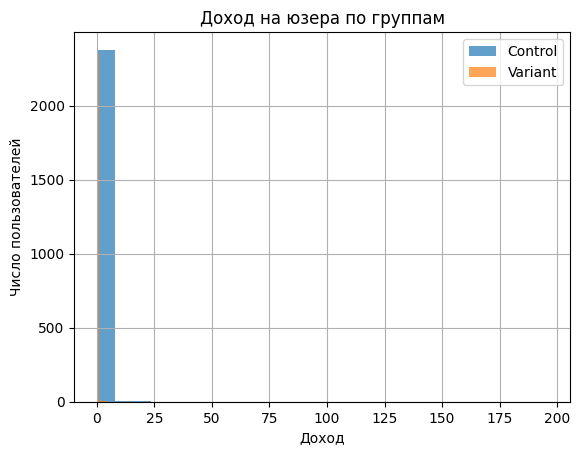

In [70]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
variant.REVENUE.hist(bins = 25, alpha =0.7, label='Variant')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

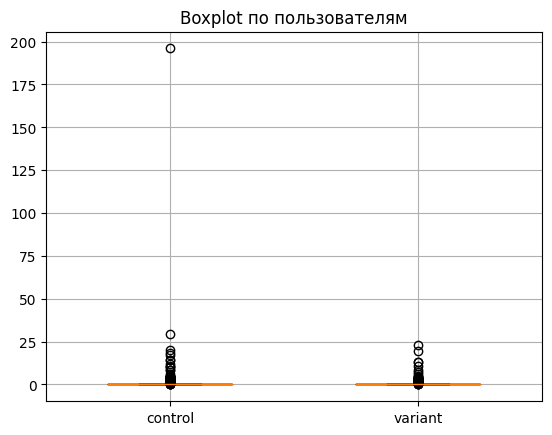

In [72]:
plt.boxplot([control.REVENUE,variant.REVENUE],
            labels=['control','variant'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Т.к. распределение не является нормальным, применяем критерий Манна-Уитни.

In [75]:
import scipy.stats as st

mw_stats = st.mannwhitneyu(x=control.REVENUE.values, y=variant.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

In [90]:
stats.ttest_ind(control.REVENUE.values, variant.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

Проверим мощность теста

In [76]:
C_mean = control.REVENUE.values.mean()

T_mean = variant.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = variant.REVENUE.values.std()

In [77]:
print(len(control.REVENUE.values), len(variant.REVENUE.values))

2390 2393


In [78]:
n =  len(control.REVENUE.values)

In [79]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [80]:
ef =float((T_mean-C_mean)/ S)

In [89]:
from statsmodels.stats.power import TTestIndPower

alpha = 0.05

analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha=alpha)

result

0.2880309627335733

##Вывод

Т.к. pvalue=0.2104875008271777, что больше alpha = 0.05, Н0 гипотеза не отвергается, т.е. статистической разницы между группами нет, но учитывая, что мощность теста около 29 процентов, мы неможем быть уверены в результатах теста.

## Рекомендации

Не рекомендуется применять изменения. Рекомендуется перезапустить тест, поставить его корректно,с предрасчётом объёма выборки и длительности теста.